In [1]:
# Mount Google Drive to access data and save models
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import os
import numpy as np

# Define paths and parameters
image_dir = '/content/drive/MyDrive/dataset/image'
mask_dir = '/content/drive/MyDrive/dataset/label'
img_height, img_width = 480, 848
batch_size = 2  # Reducing batch size to manage memory
num_classes = 5  # Number of segmentation classes

# Function to load and preprocess data
def load_data(image_dir, mask_dir, img_height, img_width):
    images = []
    masks = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '.png'))

        # Load and normalize the image
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0
        images.append(img)

        # Load the mask and map colors to class indices
        mask = load_img(mask_path, target_size=(img_height, img_width))
        mask = img_to_array(mask).astype(np.uint8)  # Convert to integer type

        # Create an empty array for the label indices
        label_mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # Map each color in the mask to a corresponding class index
        label_mask[(mask == [0, 0, 0]).all(axis=-1)] = 0           # background
        label_mask[(mask == [250, 250, 55]).all(axis=-1)] = 1      # indopoint
        label_mask[(mask == [51, 221, 255]).all(axis=-1)] = 2      # palang
        label_mask[(mask == [102, 255, 102]).all(axis=-1)] = 3     # road
        label_mask[(mask == [255, 0, 204]).all(axis=-1)] = 4       # trotoar

        masks.append(label_mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks

# U-Net Model Definition
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Custom IoU Metric
def iou_metric(y_true, y_pred):
    # Convert y_pred to class indices
    y_pred = tf.argmax(y_pred, axis=-1)  # Convert to class indices
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Reshape y_true to match y_pred's shape
    y_true = tf.squeeze(y_true, axis=-1)

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return intersection / (union + 1e-10)  # Avoid division by zero

# Data loading and preprocessing
images, masks = load_data(image_dir, mask_dir, img_height, img_width)

# Expand mask dimensions to match model output (batch_size, height, width, 1)
masks = np.expand_dims(masks, axis=-1)

# Create the model
model = unet_model()

# Compile the model with custom IoU metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', iou_metric])

# Create data augmentation generators
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Flow data through generators
image_generator = image_datagen.flow(images, batch_size=batch_size, seed=42)
mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=42)


# Create a train dataset with the appropriate batch size
train_dataset = tf.data.Dataset.from_generator(
    lambda: zip(image_generator, mask_generator),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, img_height, img_width, 1), dtype=tf.uint8)
    )
)

# Adjust steps_per_epoch if needed (make sure it's a multiple of batch size)
steps_per_epoch = len(images) // batch_size

# Train the model
model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=50)

# Save the model
model.save('/content/drive/MyDrive/dataset/unet_segmentation_model.h5')


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 110s 710ms/step - accuracy: 0.5407 - iou_metric: 0.6794 - loss: 2.4817
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 725ms/step - accuracy: 0.6687 - iou_metric: -0.0583 - loss: 0.8038
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 713ms/step - accuracy: 0.8534 - iou_metric: -5.4961 - loss: 0.4895
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 707ms/step - accuracy: 0.8065 - iou_metric: -5.4623 - loss: 0.5383
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - accuracy: 0.7771 - iou_metric: -6.5993 - loss: 0.4923
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 711ms/step - accuracy: 0.8840 - iou_metric: -7.4929 - loss: 0.3988
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - accuracy: 0.8808 - iou_metric: -9.5613 - loss: 0.3923
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 707ms/step - accuracy: 0.8898 - iou_metric: -6.9501 - loss: 0.3418
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 711ms/step - accuracy: 0.9122 - iou_metric: -3.9468 - loss: 0.2978
Epoch 10/50
31/31 ━

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/dataset2'  # Update with your dataset path in Google Drive
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 288, 512
batch_size = 8  # Meningkatkan batch size untuk GPU jika memori mencukupi

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Debugging file columns
    print("Kolom di file _classes.csv:", df.columns.tolist())

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()  # Remove extra spaces
        class_mapping[pixel_value] = len(class_mapping)  # Assign unique numerical index

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)  # Load class mapping for the folder
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training data and update num_classes
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

# Ensure the same number of classes across train and val
if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train  # Set the number of classes

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("Training the model...")
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

model.fit(train_images, train_masks,
          validation_data=(val_images, val_masks),
          epochs=50,
          batch_size=batch_size,
          callbacks=[checkpoint])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is GPU available: False
Available GPU: []
Loading training data...
Loading classes from /content/drive/MyDrive/dataset2/train/_classes.csv...
Kolom di file _classes.csv: ['Pixel Value', ' Class']
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Loading validation data...
Loading classes from /content/drive/MyDrive/dataset2/valid/_classes.csv...
Kolom di file _classes.csv: ['Pixel Value', ' Class']
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Building the model...
Training the model...
Epoch 1/50
  1/158 ━━━━━━━━━━━━━━━━━━━━ 5:53:51 135s/step - accuracy: 0.0862 - loss: 1.6179

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Define paths
base_dir = '/content/drive/MyDrive/dataset2'
test_dir = os.path.join(base_dir, 'test')  # Update with your test dataset path
model_path = '/content/drive/MyDrive/dataset2/best_model.keras'  # Path to the saved best model
output_dir = '/content/drive/MyDrive/dataset2/test_results'  # Folder to save the test results

# Redefine global parameters
img_height, img_width = 288, 512
batch_size = 8  # Match with training batch size

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the best model
print("Loading the best model...")
model = tf.keras.models.load_model(model_path)

# Function to load and preprocess test data
def load_test_data(folder):
    images, file_names = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)
            file_names.append(file_name)

    images = np.array(images)
    return images, file_names

# Load test data
print("Loading test data...")
test_images, test_file_names = load_test_data(test_dir)

# Predict on test images
print("Running predictions...")
predictions = model.predict(test_images, batch_size=batch_size)

# Function to visualize predictions
def visualize_predictions(images, predictions, file_names, output_dir):
    for i in range(len(images)):
        image = images[i]
        prediction = np.argmax(predictions[i], axis=-1)  # Convert probabilities to class indices

        # Ensure prediction is resized properly (optional, if resizing is really needed)
        if prediction.shape != (img_height, img_width):
            prediction = tf.image.resize(tf.expand_dims(prediction, axis=-1),
                                          (img_height, img_width),
                                          method='nearest').numpy().squeeze()

        # Plot original image and prediction side by side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image)

        plt.subplot(1, 2, 2)
        plt.title("Prediction")
        plt.imshow(prediction, cmap='jet')  # Using a colormap for visualization

        # Save the result
        output_path = os.path.join(output_dir, file_names[i].replace('.jpg', '_result.png'))
        plt.savefig(output_path)
        plt.close()
        print(f"Saved result to {output_path}")


# Visualize predictions
print("Visualizing predictions...")
visualize_predictions(test_images, predictions, test_file_names, output_dir)

print("Testing complete. Results saved to:", output_dir)


Loading the best model...
Loading test data...
Running predictions...
2/8 ━━━━━━━━━━━━━━━━━━━━ 4:23 44s/step

Loading the best model...
Preprocessing test image...
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Visualizing result...


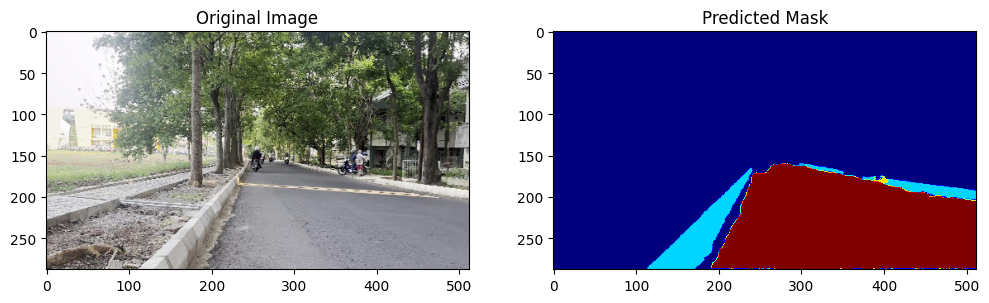

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Path to the test image and model
test_image_path = '/content/drive/MyDrive/dataset2/test/image_447_jpg.rf.8fca1caae9b438461e48967b4b7ca830.jpg'  # Update with your test image path
best_model_path = '/content/drive/MyDrive/dataset2/best_model.keras'

# Redefine global parameters
img_height, img_width = 288, 512
batch_size = 8  # Match with training batch size

# Load the trained model
print("Loading the best model...")
model = tf.keras.models.load_model(best_model_path)

# Load and preprocess the test image
def preprocess_image(image_path, target_size):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image_array  # Add batch dimension and return original image for visualization

# Preprocess the test image
print("Preprocessing test image...")
input_image, original_image = preprocess_image(test_image_path, (img_height, img_width))

# Run prediction
print("Running prediction...")
prediction = model.predict(input_image)
predicted_mask = np.argmax(prediction[0], axis=-1)  # Convert probabilities to class indices

# Visualize the result
def visualize_result(original_image, predicted_mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='jet')  # Using colormap for better visualization

    plt.show()

print("Visualizing result...")
visualize_result(original_image, predicted_mask)
